# PCA Figure

A recapitulation of Jess' primer figure but written in python by Rob

In [15]:
import os
import sys
from random import randint

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from adjustText import adjust_text

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
# load the data table
df = pd.read_csv("../MinION/Taxonomy/Minion_read_based_annotations_species_rawcounts.tsv.gz", sep='\t', compression='gzip')
df = df[df['taxonomy'].str.contains('k__Bacteria')]
df = df[~df['taxonomy'].str.endswith('s__')]
df = df[~df['taxonomy'].str.endswith('g__')]
df = df[~df['taxonomy'].str.contains('g__;')]
df = df.set_index('taxonomy')
df.index = df.index.str.split(';').str[-1]

df = df.T

df.head()

taxonomy,s__Candidatus Stahlbacteria bacterium,s__Candidatus Chromulinivorax destructor,s__Bradymonas sediminis,s__Microvenator marinus,s__Candidatus Acidulodesulfobacterium acidiphilum,s__Acanthopleuribacter pedis,s__Candidatus Sulfopaludibacter sp. SbA4,s__Edaphobacter aggregans,s__Granulicella sp. WH15,s__Candidatus Sulfotelmatobacter sp. SbA7,...,s__Pelagicoccus mobilis,s__Puniceicoccus vermicola,s__Chthoniobacter flavus,s__Pedosphaera sp. Tous-C6FEB,s__Akkermansia muciniphila,s__Akkermansia sp.,s__Brevifollis gellanilyticus,s__Luteolibacter marinus,s__Verrucomicrobium sp. GAS474,s__Candidatus Eremiobacter sp. RRmetagenome_bin22
825012_20181120_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698917_20171207_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1586713_20180309_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
748160_20180321_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1593973_20180504_S,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
# Load metadata table
# This is generic so we can copy/paste. Yes, it should be a function, but its not.

sequence_type = 'minion_ID'
# sequence_type = 'MGI_ID'

metadata = pd.read_csv("../Metadata/Metadata20241026.txt", encoding='windows-1252', sep="\t", index_col=0)
metadata = metadata[~metadata[sequence_type].isna()]
todrop = []
for s in metadata[sequence_type]:
    if s not in df.index:
        print(f"ERROR: {s} not found in data frame, dropped from metadata", file=sys.stderr)
        todrop.append(s)

metadata.drop(todrop, inplace=True)

todrop = []
for s in df.index:
    if not metadata[sequence_type].str.contains(s).any():
        print(f"ERROR: {s} not found in metadata, dropped from dataframe", file=sys.stderr)
        todrop.append(s)
df.drop(todrop, inplace=True)
        
if metadata.shape[0] != df.shape[0]:
    print(f"ERROR: we have {metadata.shape[0]} rows in metadata and {df.shape[0]} data rows", file=sys.stderr)
metadata.head()

ERROR: 698917_20180119_S not found in data frame, dropped from metadata
ERROR: 770590_20170925_S not found in data frame, dropped from metadata
ERROR: 1447437_20171212_S not found in data frame, dropped from metadata
ERROR: 1588281_20180508_S not found in data frame, dropped from metadata
ERROR: 1590009_20171212_S not found in data frame, dropped from metadata
ERROR: 1651490_20171215_S not found in data frame, dropped from metadata
ERROR: 1316979_20171215_S not found in metadata, dropped from dataframe
ERROR: 1255498_20171212_S not found in metadata, dropped from dataframe
ERROR: 698917_20190119_S not found in metadata, dropped from dataframe
ERROR: 1112926_20171212_S not found in metadata, dropped from dataframe
ERROR: 1598281_20180508_S not found in metadata, dropped from dataframe


,minion_ID,MGI_ID,pwCF_ID,Sample date,IP vs OP,Hospital,Room,Age,Age groups,Paediatric vs Adult,...,DNA Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total Clusters Passing Filter (Million),Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171
NAME,,,,,,,,,,,,,,,,,,,,,
623361_20180123_S,623361_20180123_S,623361_20180123_S,623361,1/23/2018,OP,RAH,Chest Clinic 9,18,4,Adult,...,33.60,GAGATTCC,GGCTCTGA,468,2.4,NaN,NaN,NaN,NaN,NaN
639354_20171206_S,639354_20171206_S,639354_20171206_S,639354,12/06/2017,IP,WCH,Adolescent 10,17,3,Paediatric,...,20.80,ATTACTCG,TAATCTTA,337,4.9,NaN,NaN,NaN,NaN,NaN
642660_20180601_S,642660_20180601_S,642660_20180601_S,642660,6/01/2018,IP,WCH,Adol Rm 11,17,3,Paediatric,...,21.80,GAATTCGT,GGCTCTGA,491,4.8,NaN,NaN,NaN,NaN,NaN
650003_20180207_S,650003_20180207_S,650003_20180207_S,650003,2/07/2018,IP,WCH,Adol Room 1,17,3,Paediatric,...,8.28,GAATTCGT,ATAGAGGC,476,5.7,NaN,NaN,NaN,NaN,NaN
658355_20171204_S,658355_20171204_S,658355_20171204_S,658355,12/04/2017,OP,WCH,Gilbert S Meeting,16,3,Paediatric,...,16.60,CTGAAGCT,AGGCGAAG,507,4.5,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='s__Pseudomonas aeruginosa', ylabel='Density'>

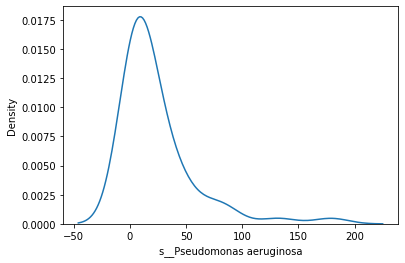

In [18]:
sns.kdeplot(data=df['s__Pseudomonas aeruginosa'])

<Axes: xlabel='s__Pseudomonas aeruginosa', ylabel='Count'>

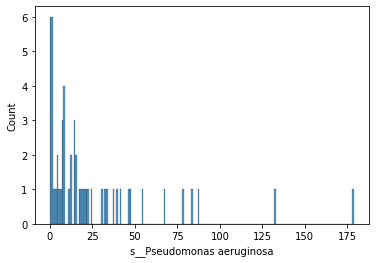

In [19]:
sns.histplot(data=df['s__Pseudomonas aeruginosa'], binwidth=1)

In [20]:
# Create some bins for the sizes
# Define the bins and labels
# Non zero mean is the mean of all the non zero values
genus = 's__Pseudomonas aeruginosa'
mn = np.mean(df[df[genus] > 0][genus])
md = np.median(df[df[genus] > 0][genus])
print(f"The mean for {genus} is {mn} and the median is {md}", file=sys.stderr)

nonzeromean = np.median(df[df[genus] > 0][genus])
bins = [-1, 0, nonzeromean/2, nonzeromean*2, float('inf')]  # Include -1 to capture 0 in 'small'
labels = ['small', 'medium', 'large']
sizelist = [50, 200, 500, 1000]
marker_shapes = ['s', 'V', '^', 'o'] # see https://seaborn.pydata.org/tutorial/properties.html#marker

# Create a new column 'size' based on the conditions
sizes = list(pd.cut(df['s__Pseudomonas aeruginosa'], bins=bins, labels=sizelist))
markers = list(pd.cut(df['s__Pseudomonas aeruginosa'], bins=bins, labels=marker_shapes))

The mean for s__Pseudomonas aeruginosa is 26.857142857142858 and the median is 14.0


In [21]:
# Normalization/Transformation
# Square root transform
sqrt_df = np.sqrt(df)

# perform the PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(sqrt_df)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings with feature names
# Select the top 5 most important loadings
loadings_df = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]


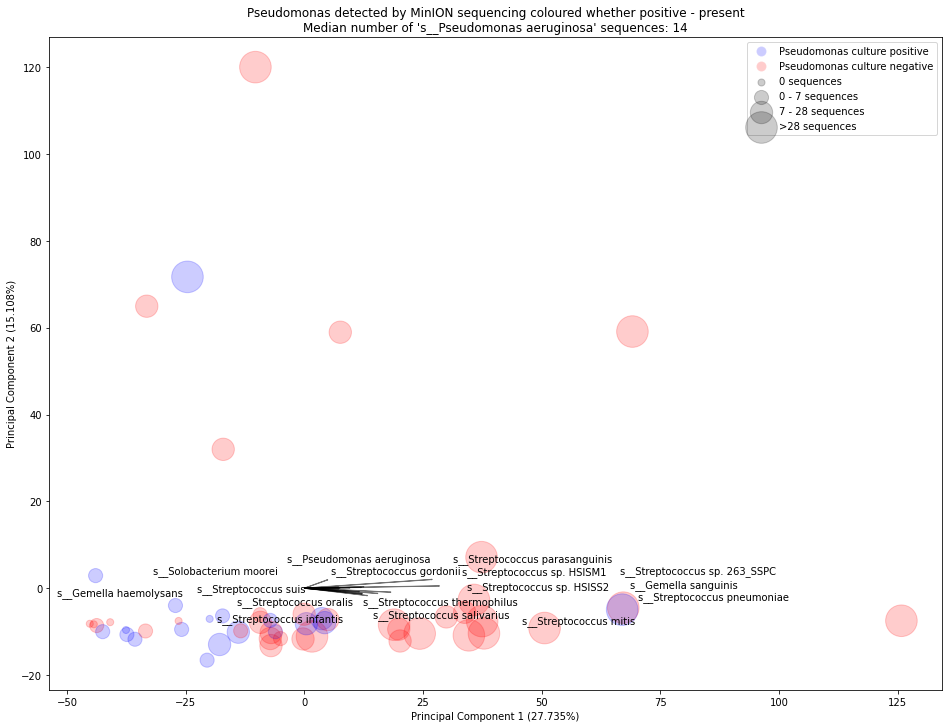

In [22]:
# Map colors based on the metadata column
colours = np.where(metadata['CS_Pseudomonas aeruginosa'] == 1, 'blue', 'red')

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MinION sequencing coloured whether positive - present' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('s__Pseudomonas aeruginosa')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])

plt.savefig('img/MinION_species_pseudomonas_present.png')
# Show the plot
plt.show()

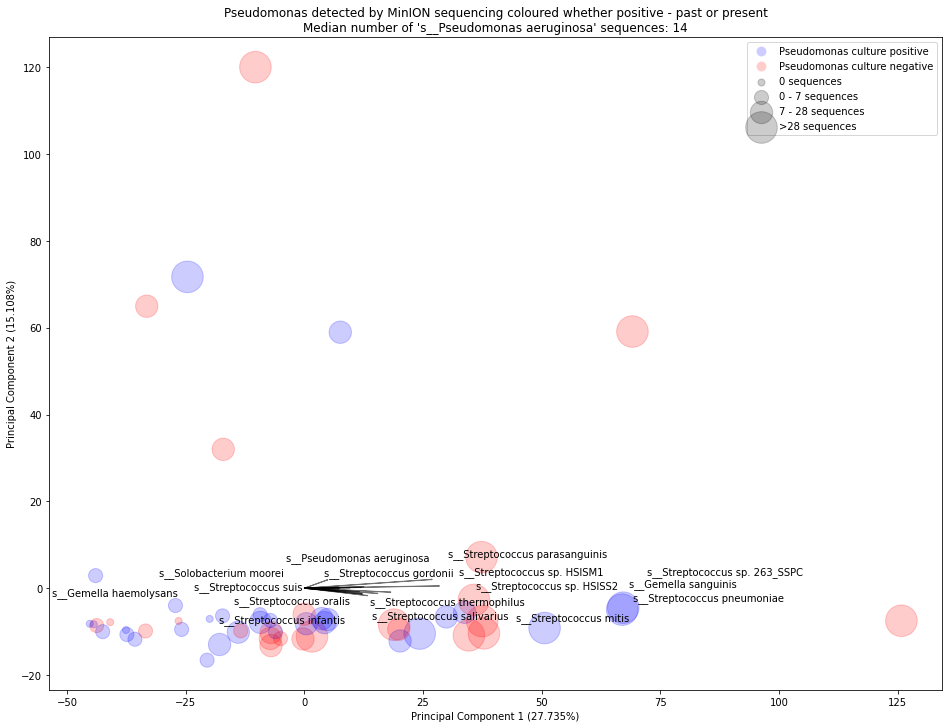

In [23]:
columns_to_check = ['CS_Pseudomonas aeruginosa', 'P12M_2_Pseudomonas aeruginosa']
colours = metadata[columns_to_check].isin([1]).any(axis=1).map({True: 'blue', False: 'red'})

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MinION sequencing coloured whether positive - past or present' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('s__Pseudomonas aeruginosa')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


plt.savefig('img/MinION_species_pseudomonas_past_present.png')
# Show the plot
plt.show()

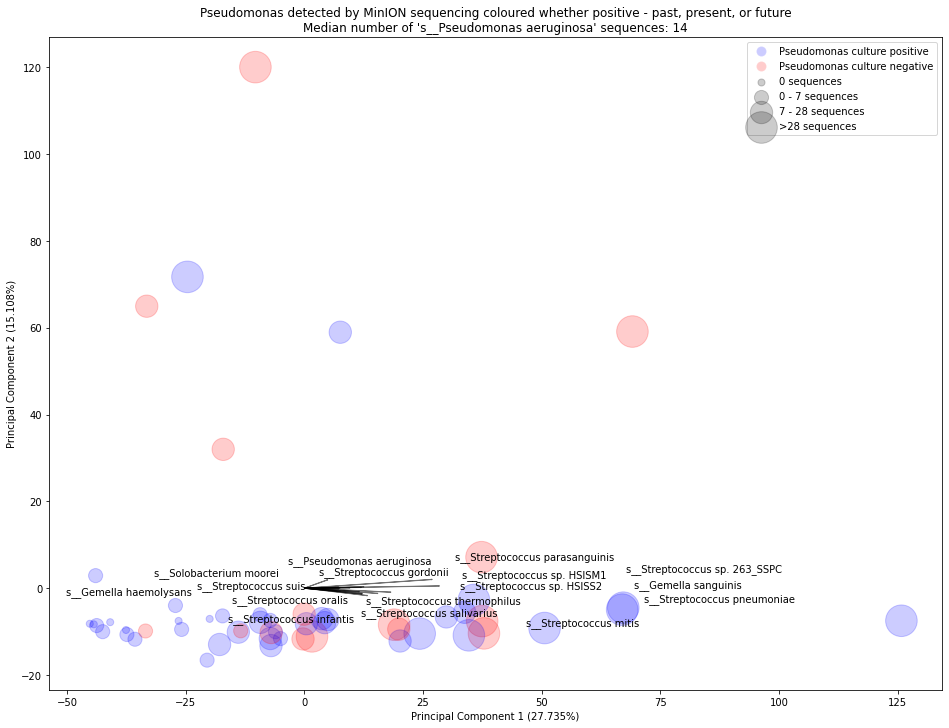

In [24]:
columns_to_check = ['CS_Pseudomonas aeruginosa', 'P12M_2_Pseudomonas aeruginosa', 'N12M_Pseudomonas aeruginosa']
colours = metadata[columns_to_check].isin([1]).any(axis=1).map({True: 'blue', False: 'red'})

# Plot the PCA results
plt.figure(figsize=(16, 12))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours, s=sizes)
plt.title('Pseudomonas detected by MinION sequencing coloured whether positive - past, present, or future' + f"\nMedian number of '{genus}' sequences: {md:.0f}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('s__Pseudomonas aeruginosa')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))

    
adjust_text(texts)

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)
small_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} sequences', 
                        alpha=0.2, s=sizelist[0])
med1_patch = plt.scatter([], [], color='k', label=f'{bins[1]:.0f} - {bins[2]:.0f} sequences', 
                        alpha=0.2, s=sizelist[1])
med2_patch = plt.scatter([], [], color='k', label=f'{bins[2]:.0f} - {bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[2])
big_patch = plt.scatter([], [], color='k', label=f'>{bins[3]:.0f} sequences', 
                        alpha=0.2, s=sizelist[3])

plt.legend(handles=[blue_patch, red_patch, small_patch, med1_patch, med2_patch, big_patch])


plt.savefig('img/MinION_species_pseudomonas_past_present_future.png')
# Show the plot
plt.show()